<a href="https://colab.research.google.com/github/santule/ERA/blob/main/S13/model_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/AI/ERA_course/session13_part3

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/AI/ERA_course/session13_part3


### LOAD LIGHTNING MODEL

In [ ]:
!pip install pytorch-lightning --quiet
!pip install lightning-bolts --quiet

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger
import config
import torch
import torch.optim as optim
import matplotlib

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    plot_couple_examples,
    accuracy_fn,
    get_loaders,
    non_max_suppression,
    plot_image
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# custom functions for yolo

# loss function for yolov3
loss_fn = YoloLoss()
def criterion(out, y,anchors):
  loss = (  loss_fn(out[0], y[0], anchors[0])
            + loss_fn(out[1], y[1], anchors[1])
            + loss_fn(out[2], y[2], anchors[2])
            )
  return loss

# accuracy function for yolov3
def accuracy_fn(y, out, threshold,
                correct_class, correct_obj,
                correct_noobj, tot_class_preds,
                tot_obj, tot_noobj):

  for i in range(3):

      obj = y[i][..., 0] == 1 # in paper this is Iobj_i
      noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

      correct_class += torch.sum(
          torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
      )
      tot_class_preds += torch.sum(obj)

      obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
      correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
      tot_obj += torch.sum(obj)
      correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
      tot_noobj += torch.sum(noobj)

  return((correct_class/(tot_class_preds+1e-16))*100,
         (correct_noobj/(tot_noobj+1e-16))*100,
         (correct_obj/(tot_obj+1e-16))*100)

# pytorch lightning
class LitYolo(LightningModule):
    def __init__(self, num_classes=config.NUM_CLASSES, lr=config.LEARNING_RATE,weight_decay=config.WEIGHT_DECAY,threshold=config.CONF_THRESHOLD,my_dataset=None):
        super().__init__()

        self.save_hyperparameters()
        self.model = YOLOv3(num_classes=self.hparams.num_classes)
        self.my_dataset = my_dataset
        self.criterion = criterion
        self.accuracy_fn = accuracy_fn
        self.tot_class_preds, self.correct_class = 0, 0
        self.tot_noobj, self.correct_noobj = 0, 0
        self.tot_obj, self.correct_obj = 0, 0
        self.scaled_anchors = 0

    def set_scaled_anchor(self, scaled_anchors):
      self.scaled_anchors = scaled_anchors

    def forward(self, x):
      out = self.model(x)
      return out

    def on_train_epoch_start(self):
      # Set a new image size for the dataset at the beginning of each epoch
      size_idx = random.choice(range(len(config.IMAGE_SIZES)))
      self.my_dataset.set_image_size(size_idx=0)
      self.set_scaled_anchor((
          torch.tensor(config.ANCHORS)
          * torch.tensor(config.S[size_idx]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
      ))

    def on_validation_epoch_start(self):
      self.set_scaled_anchor((
          torch.tensor(config.ANCHORS)
          * torch.tensor(config.S[1]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
      ))

    def on_test_epoch_start(self):
      self.set_scaled_anchor((
          torch.tensor(config.ANCHORS)
          * torch.tensor(config.S[1]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
      ))


    def training_step(self, batch, batch_idx):
        x, y = batch
        out  = self(x)
        loss = self.criterion(out,y,self.scaled_anchors)
        acc  = self.accuracy_fn(y,out,self.hparams.threshold,self.correct_class,
                                                                     self.correct_obj,
                                                                     self.correct_noobj,
                                                                     self.tot_class_preds,
                                                                     self.tot_obj,
                                                                     self.tot_noobj)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log_dict({"class_accuracy": acc[0], "no_object_accuracy": acc[1], "object_accuracy":acc[2]},prog_bar=True,on_step=False, on_epoch=True)
        return loss


    def evaluate(self, batch, stage=None):
        x, y = batch
        test_out = self(x)
        loss = self.criterion(test_out,y,self.scaled_anchors)
        acc  = self.accuracy_fn(y,test_out,self.hparams.threshold,self.correct_class,
                                                                     self.correct_obj,
                                                                     self.correct_noobj,
                                                                     self.tot_class_preds,
                                                                     self.tot_obj,
                                                                     self.tot_noobj)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log_dict({"class_accuracy": acc[0], "no_object_accuracy": acc[1], "object_accuracy":acc[2]},prog_bar=True)

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = OneCycleLR(
                optimizer,
                max_lr= 1E-2,
                pct_start = 5/self.trainer.max_epochs,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_loader),
                div_factor=100,verbose=True,
                three_phase=False
            )
        return ([optimizer],[scheduler])

### EVALUATE MODEL

In [ ]:
train_dataset,test_dataset,train_eval_dataset, train_loader, test_loader, train_eval_loader = get_loaders(train_csv_path='/content/drive/MyDrive/AI/ERA_course/session13_old/PASCAL_VOC/train.csv',\
                                                           test_csv_path='/content/drive/MyDrive/AI/ERA_course/session13_old/PASCAL_VOC/test.csv')
yololit = LitYolo()
inference_model  = yololit.load_from_checkpoint("yolo3_model_multi.ckpt")


In [ ]:
# check the model's test accuracy by loading from save_checkpoint
print(f"----------Model Performance after loading from saved checkpoint----------")
trainer = Trainer(log_every_n_steps=1,
                  check_val_every_n_epoch=1,
    enable_model_summary=True,
    max_epochs=2,
    precision=16,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    logger= TensorBoardLogger("logs/"),
    default_root_dir="model/save/",
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],)

inference_model.eval()
trainer.test(inference_model.to('cuda'), test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


----------Model Performance after loading from saved checkpoint----------


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      class_accuracy       │     82.17780303955078     │
│    no_object_accuracy     │     98.79771423339844     │
│      object_accuracy      │     51.24636459350586     │
│         test_loss         │     5.259003162384033     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.259003162384033,
  'class_accuracy': 82.17780303955078,
  'no_object_accuracy': 98.79771423339844,
  'object_accuracy': 51.24636459350586}]

In [ ]:
# check class accuracy using utils
check_class_accuracy(inference_model.to('cuda'), test_loader, threshold=config.CONF_THRESHOLD)

100%|██████████| 619/619 [01:31<00:00,  6.77it/s]

Class accuracy is: 82.763969%
No obj accuracy is: 98.797569%
Obj accuracy is: 51.721943%


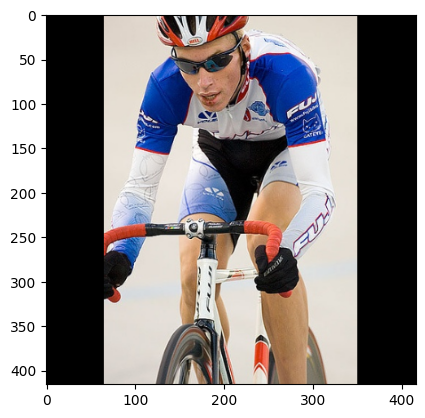

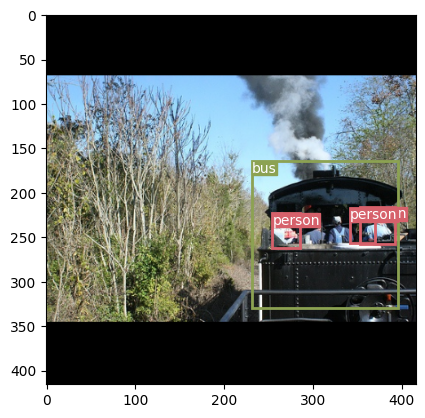

In [ ]:
# S[1] = 416
# plot examples
scaled_anchors   = (torch.tensor(config.ANCHORS) * torch.tensor(config.S[1]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)
plot_couple_examples(inference_model.to('cuda'), test_loader, 0.6, 0.5, scaled_anchors)